In [67]:
import os, shutil, random
import zarr
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import dask.array as da
from dask.diagnostics import ProgressBar
from dask.distributed import Client
import cv2 as cv
from pathlib import Path
import numcodecs
from zarr.storage import LocalStore
from sklearn.model_selection import train_test_split

In [12]:
root = '/glade/derecho/scratch/joko/synth-ros/params_200_50_20250403/subset_n1000/default/4'
file = 'ros-projection-000007-008-default.png'
img_path = os.path.join(root, file)
img = cv.imread(img_path)
img.shape

(224, 224, 3)

Notes on zarr v3:
- Lots of problems...may need to change when bugs are fixed with new iteration of zarr v3
- https://github.com/zarr-developers/zarr-python/issues/2964

# Test on n1000 subset

## a) no groups

In [57]:
def imgs2zarr(imgs, save_path):
    '''
    imgs: list of paths of images (e.g., pngs)
    save_path: where to save zarr array
    '''        
    # Load one image to get shape
    sample = np.array(Image.open(imgs[0]))
    img_shape = sample.shape
    # Create LocalStore for writing Zarr v3
    store = LocalStore(save_path)
    # Open the root group using Zarr v3
    root = zarr.open(store=store, mode="w")
    # # Set up compression codec (Blosc in this case)
    # compression = numcodecs.Blosc(cname='zstd', clevel=3, shuffle=numcodecs.Blosc.SHUFFLE)
    # Create arrays
    images_arr = root.create_array(
        name="images",
        shape=(len(imgs), *img_shape),
        chunks=(10, *img_shape),
        dtype="uint8",
        compressors=[zarr.codecs.BloscCodec(cname="zstd", clevel=3, shuffle="shuffle")]
    )
    # Write data
    for i, path in enumerate(imgs):
        img = np.array(Image.open(path))
        images_arr[i] = img 
    # save filenames as metadata
    root.attrs['filenames'] = [p.name for p in imgs]
    print("✅ Saved PNGs and filenames using Zarr v3 + LocalStore.")

In [58]:
root = '/glade/derecho/scratch/joko/synth-ros/params_200_50_20250403/subset_n1000'
subfolders = ['2ds', 'default', 'phips']
for f in subfolders:
    data_dir = Path(os.path.join(root, f))
    png_files = list(data_dir.rglob('*.png'))
    save_filename = f'{f}.zarr'
    save_path = os.path.join(root, save_filename)
    print(f'creating {save_path}...')
    imgs2zarr(png_files, save_path=save_path) # save to zarr

creating /glade/derecho/scratch/joko/synth-ros/params_200_50_20250403/subset_n1000/2ds.zarr...
✅ Saved PNGs and filenames using Zarr v3 + LocalStore.
creating /glade/derecho/scratch/joko/synth-ros/params_200_50_20250403/subset_n1000/default.zarr...
✅ Saved PNGs and filenames using Zarr v3 + LocalStore.
creating /glade/derecho/scratch/joko/synth-ros/params_200_50_20250403/subset_n1000/phips.zarr...
✅ Saved PNGs and filenames using Zarr v3 + LocalStore.


In [74]:
# check zarr files
root = '/glade/derecho/scratch/joko/synth-ros/params_200_50_20250403/subset_n1000'
subfolders = ['2ds', 'default', 'phips']
for f in subfolders:
    zarr_file = f'{f}.zarr'
    print(type(zarr_file))
    zarr_path = os.path.join(root, zarr_file)
    print(zarr_path)
    store = LocalStore(zarr_path)
    zarr_root = zarr.open(store, mode='r')
    print(zarr_root.tree())

<class 'str'>
/glade/derecho/scratch/joko/synth-ros/params_200_50_20250403/subset_n1000/2ds.zarr


/
└── images (7000, 224, 224, 3) uint8


<class 'str'>
/glade/derecho/scratch/joko/synth-ros/params_200_50_20250403/subset_n1000/default.zarr


/
└── images (7000, 224, 224, 3) uint8


<class 'str'>
/glade/derecho/scratch/joko/synth-ros/params_200_50_20250403/subset_n1000/phips.zarr


/
└── images (7000, 224, 224, 3) uint8

## b) split into train/val/test sets

In [62]:
def imgs2zarr_split(imgs, save_path, train_size=0.7, val_size=0.15, test_size=0.15):
    '''
    imgs: list of paths of images (e.g., pngs)
    save_path: where to save zarr array
    train_size: proportion of data to be used for training
    val_size: proportion of data to be used for validation
    test_size: proportion of data to be used for testing
    '''        
    # Load one image to get shape
    sample = np.array(Image.open(imgs[0]))
    img_shape = sample.shape
    
    # Create LocalStore for writing Zarr v3
    store = LocalStore(save_path)
    
    # Open the root group using Zarr v3
    root = zarr.open(store=store, mode="w")
    
    # Split the data into training, validation, and test sets
    train_imgs, temp_imgs = train_test_split(imgs, train_size=train_size)
    val_imgs, test_imgs = train_test_split(temp_imgs, train_size=val_size / (val_size + test_size))  # Adjust for combined size
    
    # Function to create arrays for each split
    def create_split_array(name, img_paths):
        img_shape = np.array(Image.open(img_paths[0])).shape
        arr = root.create_array(
            name=name,
            shape=(len(img_paths), *img_shape),
            chunks=(10, *img_shape),
            dtype="uint8",
            compressors=[zarr.codecs.BloscCodec(cname="zstd", clevel=3, shuffle="shuffle")]
        )
        for i, path in enumerate(img_paths):
            img = np.array(Image.open(path))
            arr[i] = img
        return arr
    
    # Create arrays for each split
    train_arr = create_split_array("train", train_imgs)
    val_arr = create_split_array("val", val_imgs)
    test_arr = create_split_array("test", test_imgs)
    
    # Save filenames as metadata for each split
    root.attrs['train_filenames'] = [os.path.basename(p) for p in train_imgs]
    root.attrs['val_filenames'] = [os.path.basename(p) for p in val_imgs]
    root.attrs['test_filenames'] = [os.path.basename(p) for p in test_imgs]
    
    print("✅ Saved PNGs into training, validation, and test splits using Zarr v3 + LocalStore.")

In [63]:
%%time
root = '/glade/derecho/scratch/joko/synth-ros/params_200_50_20250403/subset_n1000'
subfolders = ['2ds', 'default', 'phips']
for f in subfolders:
    data_dir = Path(os.path.join(root, f))
    png_files = list(data_dir.rglob('*.png'))
    save_filename = f'{f}-split.zarr'
    save_path = os.path.join(root, save_filename)
    print(f'creating {save_path}...')
    imgs2zarr_split(png_files, save_path=save_path, 
                    train_size=0.7, val_size=0.15, test_size=0.15) # save to zarr with splits

creating /glade/derecho/scratch/joko/synth-ros/params_200_50_20250403/subset_n1000/2ds-split.zarr...
✅ Saved PNGs into training, validation, and test splits using Zarr v3 + LocalStore.
creating /glade/derecho/scratch/joko/synth-ros/params_200_50_20250403/subset_n1000/default-split.zarr...
✅ Saved PNGs into training, validation, and test splits using Zarr v3 + LocalStore.
creating /glade/derecho/scratch/joko/synth-ros/params_200_50_20250403/subset_n1000/phips-split.zarr...
✅ Saved PNGs into training, validation, and test splits using Zarr v3 + LocalStore.
CPU times: user 2min 21s, sys: 12.9 s, total: 2min 34s
Wall time: 3min 20s


In [73]:
# check zarr files
root = '/glade/derecho/scratch/joko/synth-ros/params_200_50_20250403/subset_n1000'
subfolders = ['2ds', 'default', 'phips']
for f in subfolders:
    zarr_file = f'{f}-split.zarr'
    print(type(zarr_file))
    zarr_path = os.path.join(root, zarr_file)
    print(zarr_path)
    store = LocalStore(zarr_path)
    zarr_root = zarr.open(store, mode='r')
    print(zarr_root.tree())

<class 'str'>
/glade/derecho/scratch/joko/synth-ros/params_200_50_20250403/subset_n1000/2ds-split.zarr


/
├── test (1050, 224, 224, 3) uint8
├── train (4900, 224, 224, 3) uint8
└── val (1050, 224, 224, 3) uint8


<class 'str'>
/glade/derecho/scratch/joko/synth-ros/params_200_50_20250403/subset_n1000/default-split.zarr


/
├── test (1050, 224, 224, 3) uint8
├── train (4900, 224, 224, 3) uint8
└── val (1050, 224, 224, 3) uint8


<class 'str'>
/glade/derecho/scratch/joko/synth-ros/params_200_50_20250403/subset_n1000/phips-split.zarr


/
├── test (1050, 224, 224, 3) uint8
├── train (4900, 224, 224, 3) uint8
└── val (1050, 224, 224, 3) uint8

In [2]:
# List to store images
image_list = []
image_paths = []
source_dir = "/glade/derecho/scratch/joko/synth-ros/params_200_50_small_subset/projections"
# Loop through directories to find PNG files
for root, _, files in os.walk(source_dir):
    for file in files:
        if file.lower().endswith(".png"):  # Only process PNG images
            img_path = os.path.join(root, file)
            img = Image.open(img_path).convert('L') # Convert to grayscale
            img_arr = np.array(img)
            image_list.append(img_arr)
            image_paths.append(img_path)
len(image_list)

70

In [3]:
images_np = np.stack(image_list, axis=0)
images_np.shape

(70, 128, 128)

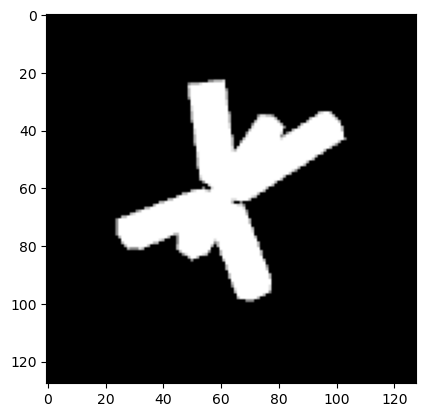

In [8]:
i = random.randint(0,69)
img = images_np[i,:,:]
plt.imshow(img, cmap='gray')

In [11]:
f = image_paths[0]
f.rsplit('/',2)

['/glade/derecho/scratch/joko/synth-ros/params_200_50_small_subset/projections',
 '6',
 'ros-projection-024988-078.png']

In [16]:
imgs = np.asarray(image_list)
imgs.shape

(70, 128, 128)

In [23]:
# create a zarr DirectoryStore from these images
labels = []
for f in image_paths:
    n_arms = int(f.rsplit('/',2)[1])
    labels.append(n_arms)

# Define the directory where the Zarr store will be saved
zarr_dir = 'zarr_test_ds' 

# Check if the directory exists and create it if it doesn't
if not os.path.exists(zarr_dir):
    os.makedirs(zarr_dir)

# Create a Zarr store in the specified directory
root = zarr.open(zarr_dir, mode='w')

# Create a root group (which can hold arrays and other groups)
images = root.create_group('images')

# Create a 3D array (e.g., 10 images of size 100x100 with 3 channels, dtype uint8)
shape = imgs.shape  # 10 images of size 100x100 with 3 color channels
batch_size = 10
chunks = (batch_size, imgs.shape[1], imgs.shape[2])  # Chunking: chunks of 1 image at a time
dtype = 'uint8'  # Data type of the array (uint8 for RGB images)
total_images = imgs.shape[0]

# Create the Zarr array within the root group
images_arr = images.create('images_arr', shape=shape, dtype=dtype, chunks=chunks)

# Function to simulate loading a batch of image data (for demonstration purposes)
def load_image_batch(start_idx, batch_size, data):
    end_idx = start_idx + batch_size
    batch = data[start_idx:end_idx, :, :]
    return batch

# Iterate over the image dataset and write data in batches
for start_idx in range(0, total_images, batch_size):
    # Load a batch of images
    image_batch = load_image_batch(start_idx, batch_size, imgs)
    
    # Write the batch to the Zarr array (using slicing to place data in the correct position)
    images_arr[start_idx:start_idx+batch_size] = image_batch

    # Optionally, print progress
    print(f"Processed {start_idx + batch_size}/{total_images} images...")

print(f"All image data has been saved to the Zarr store at {zarr_dir}")

# Save metadata about the array in .zattrs (automatic with Zarr)
print(f"Zarr dataset has been saved to: {zarr_dir}")

# Optionally, you can print out the metadata to see the chunking, shape, dtype, etc.
print("Array metadata (zattrs):")
print(images_arr.attrs)

Processed 10/70 images...
Processed 20/70 images...
Processed 30/70 images...
Processed 40/70 images...
Processed 50/70 images...
Processed 60/70 images...
Processed 70/70 images...
All image data has been saved to the Zarr store at zarr_test_ds
Zarr dataset has been saved to: zarr_test_ds
Array metadata (zattrs):


Metadata for 'images' array:
plotting img 18
images chunked as: (10, 128, 128)


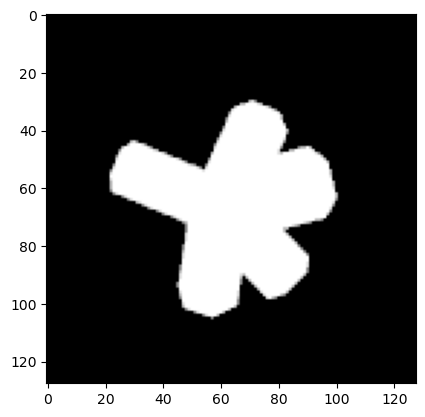

In [32]:
# Load the Zarr store from the directory
root = zarr.open('zarr_test_ds', mode='r')

# Access the 'images' group
images_grp = root['images']

# load the images_arr array
images_arr = images_grp['images_arr']

# Print the metadata (attributes) of the array in a more readable format
print("Metadata for 'images' array:")
for key, value in images_arr.attrs.items():
    print(f"{key}: {value}")

# Access and plot random image
rand_idx = random.randint(0,70)
print(f'plotting img {rand_idx}')
img = images_arr[rand_idx]
print(f'images chunked as: {images_arr.chunks}')
plt.imshow(img, cmap='gray')  # Use 'gray' colormap for grayscale images
plt.show()

In [36]:
# connect to dask distributed cluster
# from dask.distributed import Client
from dask_jobqueue import PBSCluster
n_cores = 4
cluster = PBSCluster(account='UPSU0052', queue='casper', memory='16GB', cores=n_cores, processes=1, walltime='01:00:00')
# cluster.adapt(minimum=4, maximum=16) # adaptive 
cluster.scale(n_cores) # set to constant number of cores
# client = Client(cluster)
client = cluster.get_client()
client

In [37]:
# The dashboard link will be displayed in the notebook output
print(client)

<Client: 'tcp://127.0.0.1:40339' processes=1 threads=1, memory=16.00 GiB>


In [ ]:
# You can now run some computation and view the task progress in the dashboard
result = dask_images_arr.sum().compute()

# Print result
print(f"Sum of the array: {result}")

# Create zarr dataset from png (serial)

In [66]:
# create a zarr file from all the images
# Define source directory where images are stored
source_dir = "/glade/derecho/scratch/joko/synth-ros/params_200_50-debug-20250316/projections"

# Define destination Zarr file
zarr_file = "/glade/derecho/scratch/joko/synth-ros/params_200_50-debug-20250316/projections/projections.zarr"

# get list of all img paths
relative_paths_txt = os.path.join(source_dir, 'img_relative_paths.txt')
# Open the file and read lines into a list
with open(relative_paths_txt, "r") as file:
    lines = file.readlines()  # Includes newline characters
relative_paths = [line.strip() for line in lines]
png_files=[]
for p in relative_paths:
    full_path = os.path.join(source_dir, p.split('/',1)[1])
    png_files.append(full_path)
# Open a Zarr group (or create one if it doesn't exist)
res = 128
zarr_group = zarr.create_group(zarr_file, overwrite=True)
n_chunk = 10000
n_data = len(png_files)
# Store in Zarr
images = zarr_group.create_array("images", shape=(n_data, res, res), chunks=(n_chunk, res, res), dtype=np.float64)
paths = zarr_group.create_array("paths", shape=(n_data,), chunks=(n_chunk,), dtype=object)  # Store file paths as metadata

# # List to store images
# image_list = []
# image_paths = []

for i in range(0, n_data, n_chunk):
    print(f'i: {i}')
    batch_size = min(n_chunk, n_data - i)
    print(f'batch_size: {batch_size}')
    img_list = []
    for j in range(i, i+batch_size):
        img_path = png_files[j]
        img = Image.open(img_path).convert('L') # Convert to grayscale
        img_arr = np.array(img)
        img_list.append(img_arr)
    images_np = np.stack(img_list, axis=0)
    images[i:(i+batch_size)] = images_np
    paths[i:(i+batch_size)] = png_files[i:(i+batch_size)]

/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)


i: 0
batch_size: 10000
i: 10000
batch_size: 10000
i: 20000
batch_size: 10000


KeyboardInterrupt: 

/glade/derecho/scratch/joko/synth-ros/params_200_50_small_subset/projections/6/ros-projection-028524-041.png


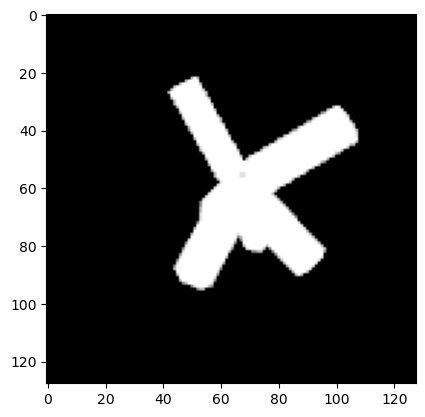

In [54]:
i = random.randint(0,len(png_files))
img = images[i]
filename = paths[i]
print(filename)
plt.imshow(img, cmap='gray')

In [55]:
print(type(images))
print(type(paths))

<class 'zarr.core.array.Array'>
<class 'list'>


In [52]:
list(zarr_group.keys())

/glade/u/apps/opt/conda/envs/npl-2025a/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:44: UserWarning: The codec `vlen-utf8` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)


['images', 'paths']

In [53]:
print(zarr_group['paths'].info)

Type               : Array
Zarr format        : 3
Data type          : DataType.string
Shape              : (70,)
Chunk shape        : (70,)
Order              : C
Read-only          : False
Store type         : LocalStore
Filters            : ()
Serializer         : VLenUTF8Codec()
Compressors        : (ZstdCodec(level=0, checksum=False),)
No. bytes          : 560


In [47]:
print(zarr.__version__)

3.0.1


# Test: png, np, opencv, zarr interoperability 

In [33]:
import cv2 as cv
import zarr
import random
import matplotlib.pyplot as plt
import numpy as np

In [36]:
# load sample png 
img_path = '/glade/derecho/scratch/joko/synth-ros/params_200_50_small_subset/projections/6/ros-projection-028524-041.png'
img = cv.imread(img_path)
print('before cvtColor')
print(type(img))
print(img.shape)
img = cv.cvtColor(img, cv.COLOR_BGR2YCR_CB)[...,0]
print('after cvtColor')
print(type(img))
print(img.shape)

before cvtColor
<class 'numpy.ndarray'>
(128, 128, 3)
after cvtColor
<class 'numpy.ndarray'>
(128, 128)


-> opencv's imread() output is a np array

In [9]:
# read in a test zarr file 
zarr_path = '/glade/derecho/scratch/joko/synth-ros/params_200_50-debug-20250316/projections/projections.zarr'
z = zarr.open_group(zarr_path, mode='r')
type(z)

zarr.core.group.Group

In [16]:
# groups: images, paths
type(z['images'])

zarr.core.array.Array

In [17]:
z_imgs = z['images']
z_imgs = z_imgs[:100, :, :]
z_imgs.shape

(100, 128, 128)

In [18]:
type(z_imgs)

numpy.ndarray

## image processing functions

In [31]:
def get_border(image, width):
    bg = np.zeros(image.shape)
    contours, _ = cv.findContours(image.copy(), cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    biggest = 0
    bigcontour = None
    for contour in contours:
        area = cv.contourArea(contour) 
        if area > biggest:
            biggest = area
            bigcontour = contour
    return cv.drawContours(bg, [bigcontour], 0, (255, 255, 255), width).astype(bool), contours 

def get_aspect_ratio(cnt):
    rect = cv.minAreaRect(cnt)
    # get length and width of contour
    x = rect[1][0]
    y = rect[1][1]
    rect_length = max(x, y)
    rect_width = min(x, y)
    phi = rect_width / rect_length
    return phi

def get_aspect_ratio_elip(cnt):
    ellipse = cv.fitEllipse(cnt)
    # Get width and height of rotated ellipse
    widthE = ellipse[1][0]
    heightE = ellipse[1][1]
    if widthE > heightE:
        phiE = heightE / widthE
    else:
        phiE = widthE / heightE
    return phiE

def get_extreme_pts(cnt):
    left = tuple(cnt[cnt[:, :, 0].argmin()][0])
    right = tuple(cnt[cnt[:, :, 0].argmax()][0])
    top = tuple(cnt[cnt[:, :, 1].argmin()][0])
    bottom = tuple(cnt[cnt[:, :, 1].argmax()][0])
    extreme_pts = np.std([left, right, top, bottom])
    return extreme_pts

def get_contour_area(cnt):
    area = cv.contourArea(cnt)
    return area

def get_contour_perimeter(cnt):
    perimeter = cv.arcLength(cnt, True)
    return perimeter

def get_min_circle(cnt):
    center ,radius = cv.minEnclosingCircle(cnt)
    perimeter_circle = 2*np.pi*radius
    area_circle = np.pi*(radius**2)
    return center, radius, perimeter_circle, area_circle

def get_area_ratio(cnt):
    area = get_contour_area(cnt)
    _,_,_,area_circle = get_min_circle(cnt)
    area_ratio = area/area_circle
    return area_ratio

def get_complexity(cnt):
    _, radius, _, _ = get_min_circle(cnt)
    area = get_contour_area(cnt)
    perimeter = get_contour_perimeter(cnt)
    Ac = np.pi * radius ** 2
    complexity = 10*(0.1-(area / (np.sqrt(area / Ac) * perimeter ** 2)))
    return complexity

def get_circularity(cnt):
    area = get_contour_area(cnt)
    perimeter = get_contour_perimeter(cnt)
    circularity = 4*np.pi*(area/(perimeter**2))
    return circularity

## process sample image

In [45]:
# get random image from zarr array of imgs and perform some opencv functions
n_random = random.randint(0, len(z_imgs))
img_random = z_imgs[n_random, :, :]
print(img_random.shape)
img_random = img_random.astype(np.uint8) # try converting to uint8 type from float

(128, 128)


In [49]:
print(img_random.min())
print(img_random.max())
print(img_random.dtype)

0
255
uint8


In [48]:
# run processing functions on img
img=img_random
_, contours = get_border(img, 5)
cnt = contours[0]
aspect_ratio = get_aspect_ratio(cnt)
aspect_ratio_elip = get_aspect_ratio_elip(cnt)
extreme_pts = get_extreme_pts(cnt)
contour_area = get_contour_area(cnt)
contour_perimeter = get_contour_perimeter(cnt)
area_ratio = get_area_ratio(cnt)
complexity = get_complexity(cnt)
circularity = get_circularity(cnt)
img_features = [aspect_ratio, aspect_ratio_elip, extreme_pts, \
    contour_area, contour_perimeter, area_ratio, \
    complexity, circularity]
print(img_features)

[0.8143499982196694, 0.8782426068060779, np.float64(26.323706046071855), 1939.0, 383.5046137571335, 0.40841846826339995, np.float64(0.7937072635496241), 0.16567099741241847]


Make sure that the datatype is set to "np.uint8" before feeding through opencv functions!  
The default datatype is float64, and this will result in error.